In [13]:
import numpy as np
import astropy
import math
import matplotlib.pyplot as plt
import matplotlib.colors
from kpf_etc.etc import kpf_photon_noise_estimate
from kpf_etc.etc import kpf_etc_rv

# plot spectrum as recorded by KPF
%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = [15, 4]
plt.rcParams.update({'font.size': 16})

# basic binning function
def bin_ndarray(ndarray, new_shape, operation='sum'):
    """
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.
    Number of output dimensions must match number of input dimensions.
    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation='sum')
    >>> print(n)
    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]
    """
    if not operation.lower() in ['sum', 'mean', 'average', 'avg']:
        raise ValueError("Operation {} not supported.".format(operation))
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d, c in zip(new_shape,
                                                   ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        if operation.lower() == "sum":
            ndarray = ndarray.sum(-1*(i+1))
        elif operation.lower() in ["mean", "average", "avg"]:
            ndarray = ndarray.mean(-1*(i+1))
    return ndarray

# Observational parameters
# ----------------------------
exp_time = 3600.
vmag = 14.
teff = 3000.
n_bins = 22	# number of exposure meter spectral bins spanning KPF bandpass
# ----------------------------

# ---------------Exposure meter properties--------------
# exposure time
em_readout = 1.	 # seconds, exposure meter integration time

# exposure meter parameters
exposure_meter_efficiency = 0.01	# exposure meter efficiency relative to photons collected in KPF focal plane
n_pix_spec_wid = 5. # number of exposure meter pixels in cross-dispersion
# -----------------------------

# exposure meter detector properties
# ----------------------------
n_pix_exp_meter = 2e3 # total number of exposure meter pixels in dispersion direction
n_pix_bin = n_pix_exp_meter / n_bins # approximate number of total integrated pixels per bin (?)

# noise
read_noise_pix = 13.	# ~electrons per 2D detector pixel
dark_current = 10. # electrons per 2D detector pixel per second
thermal_noise_pix = dark_current * em_readout	# ~electrons per 2D detector pixel

# compiled noise values assuming each bin is binned in software (not on-chip)
read_noise_sigma = ((n_pix_bin * n_pix_spec_wid) ** 0.5) * read_noise_pix
thermal_noise_sigma = ((n_pix_bin * n_pix_spec_wid) ** 0.5) * thermal_noise_pix
pixel_noise_sigma = (read_noise_sigma ** 2. + thermal_noise_sigma ** 2.) ** 0.5
# ----------------------------



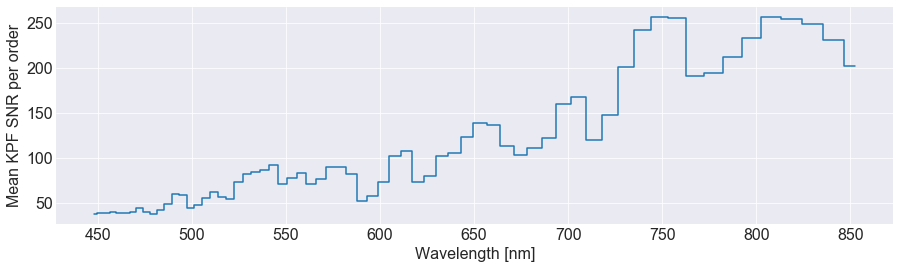

In [14]:
# calculate expected spectrum from ETC
# ----------------------------
sigma_rv_val, wvl_ord, snr_ord, dv_ord = kpf_photon_noise_estimate(teff,vmag,exp_time,quiet=True)    

# ditch last order to make the array length a nice divisible number (binning function requires non-prime number)
wvl_ord = wvl_ord[0:66]
snr_ord = snr_ord[0:66]
dv_ord = dv_ord[0:66]

# average flux per pixel in each order
flux_ord = snr_ord ** 2.

# total flux per order
# each order is about 4000 pixels across
n_pix_kpf = 4e3
flux_ord *= n_pix_kpf # multiply by total number of pixels in each order to get approximate total photons in order
# ----------------------------

# plots
# ----------------------------
plt.plot(wvl_ord, snr_ord, drawstyle='steps-mid')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Mean KPF SNR per order')
plt.show()


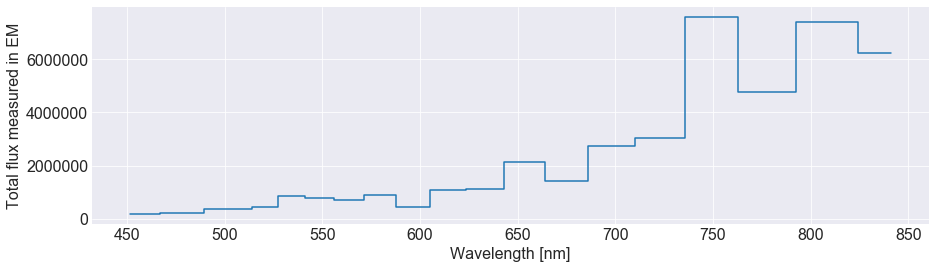

In [15]:
# ----------------------------
# calculate flux rate at exposure meter
# ----------------------------
# modulate by relative exposure meter efficiency
flux_em_ord = flux_ord * exposure_meter_efficiency

# bin exposure meter spectrum down to the specified number of spectral bins
f = np.expand_dims(flux_em_ord,axis=0)
w = np.expand_dims(wvl_ord,axis=0)

# flux 
wvl_bin = bin_ndarray(w, new_shape=(1,n_bins), operation='avg')[0]
flux_bin = bin_ndarray(f, new_shape=(1,n_bins), operation='sum')[0]

# number of exposure meter frames during exposure
n_frames = exp_time * 1. / em_readout

# time array
time = np.arange(0, em_readout * n_frames) + 0.5	# seconds, assumes 1s sampling of exposure meter
delta_t = np.amax(time) - np.amin(time)	# total exposure time

# flux rate per exposure meter spectral bin
flux_rate = flux_bin * em_readout / exp_time 	# integrated photons per exposure meter bin per exposure meter readout
# ----------------------------

# plots
# ----------------------------
plt.plot(wvl_bin, flux_bin, drawstyle='steps-mid')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Total flux measured in EM')
plt.show()
# ----------------------------


Expected observation RV uncertainty [cm/s]:  31.540154808144678
Mean KPF SNR:  108.4503492417847

Actual midpoint time:  1568.160854884761
Measured midpoint time:  1482.6202010368827
Measured timing error [s]:  85.54065384787827
Max velocity error [cm/s]:  290.8382230827861



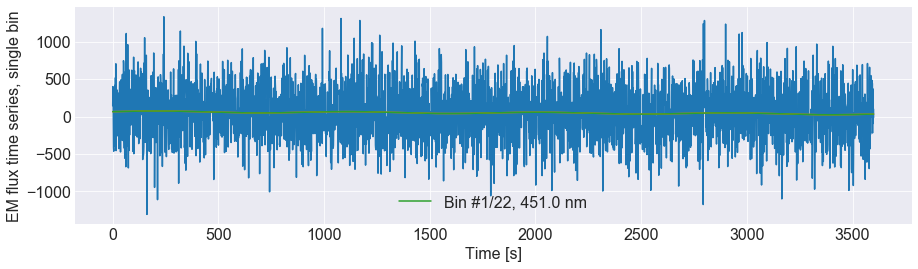


Actual midpoint time:  1568.1608548847612
Measured midpoint time:  1561.6824619090705
Measured timing error [s]:  6.478392975690667
Max velocity error [cm/s]:  22.026536117348268



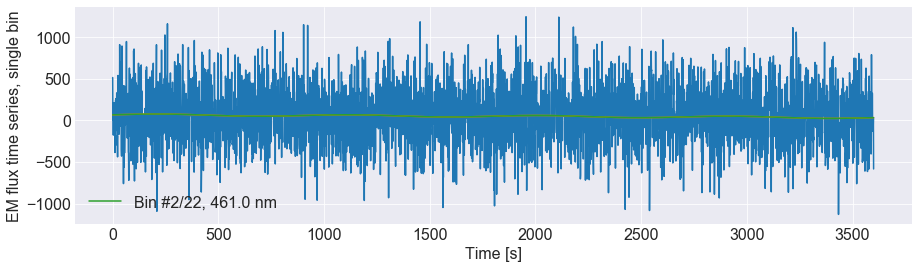


Actual midpoint time:  1568.1608548847612
Measured midpoint time:  1466.4741301455354
Measured timing error [s]:  101.68672473922584
Max velocity error [cm/s]:  345.73486411336785



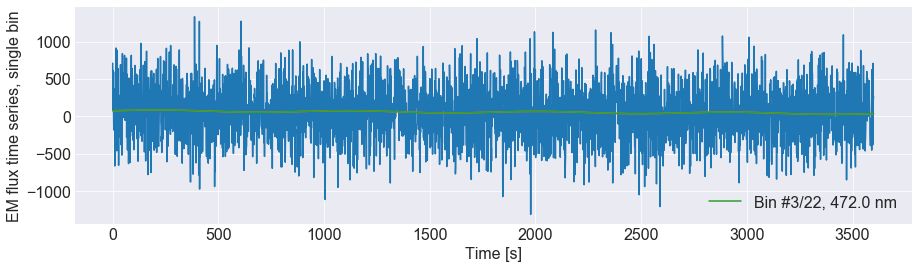


Actual midpoint time:  1568.1608548847612
Measured midpoint time:  1744.1711483486258
Measured timing error [s]:  176.01029346386463
Max velocity error [cm/s]:  598.4349977771398



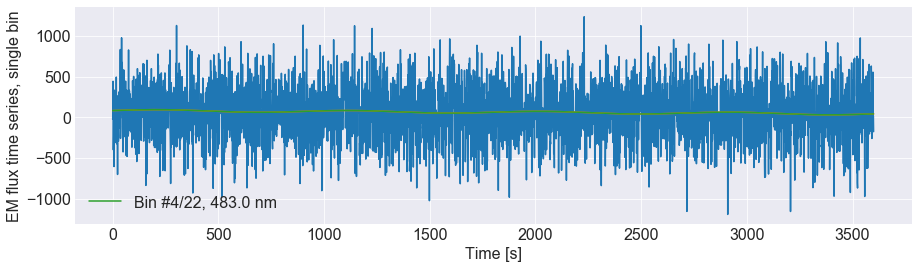


Actual midpoint time:  1568.1608548847612
Measured midpoint time:  1526.2668292780406
Measured timing error [s]:  41.89402560672056
Max velocity error [cm/s]:  142.4396870628499



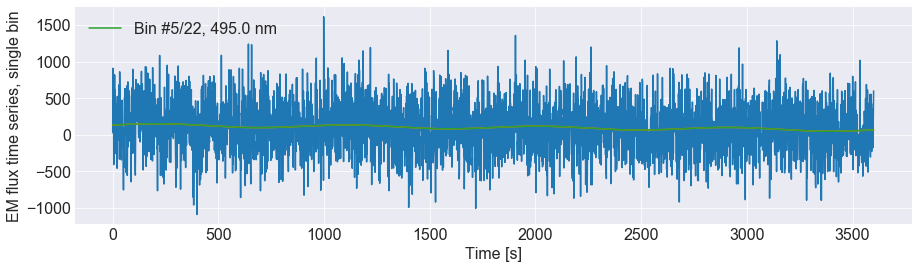


Actual midpoint time:  1568.160854884761
Measured midpoint time:  1493.6930074773254
Measured timing error [s]:  74.46784740743556
Max velocity error [cm/s]:  253.19068118528088



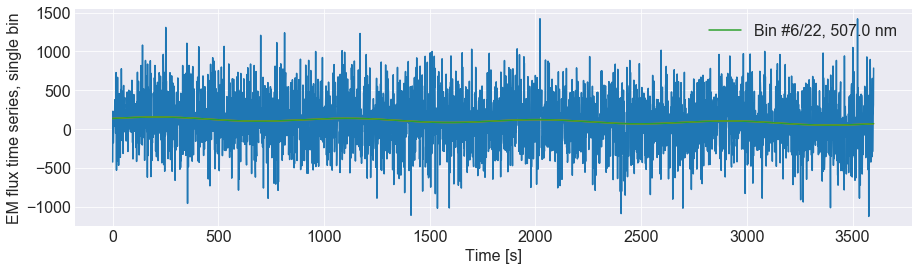


Actual midpoint time:  1568.1608548847612
Measured midpoint time:  1555.7618160352104
Measured timing error [s]:  12.399038849550834
Max velocity error [cm/s]:  42.156732088472836



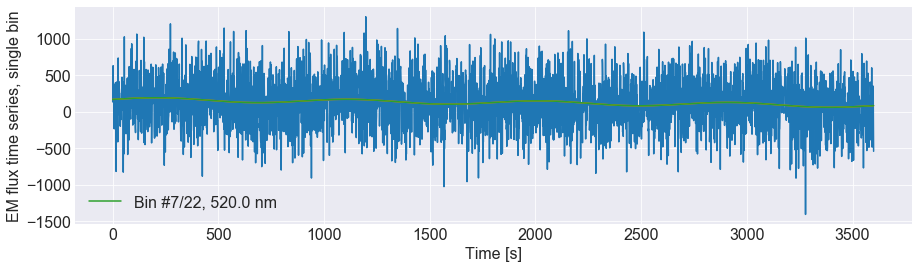


Actual midpoint time:  1568.1608548847612
Measured midpoint time:  1583.5306899171508
Measured timing error [s]:  15.369835032389574
Max velocity error [cm/s]:  52.25743911012455



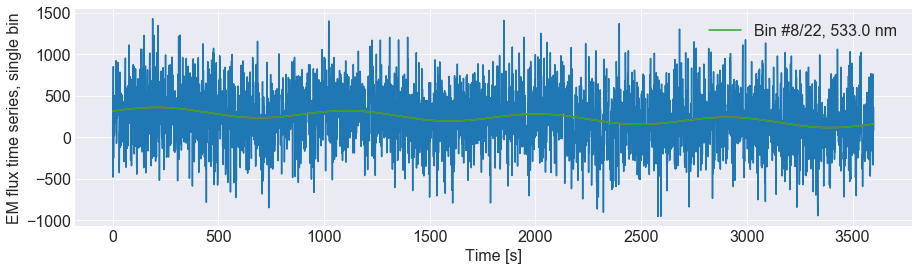


Actual midpoint time:  1568.160854884761
Measured midpoint time:  1557.1327000923334
Measured timing error [s]:  11.028154792427586
Max velocity error [cm/s]:  37.49572629425379



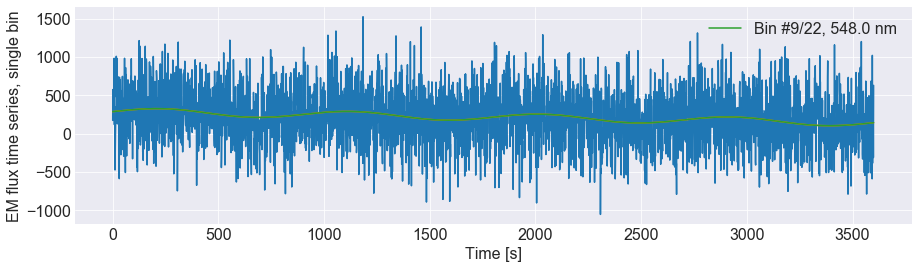


Actual midpoint time:  1568.1608548847614
Measured midpoint time:  1582.0387498995028
Measured timing error [s]:  13.877895014741398
Max velocity error [cm/s]:  47.184843050120755



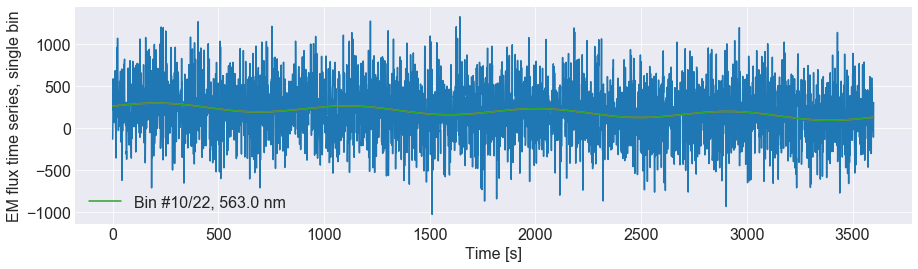


Actual midpoint time:  1568.1608548847612
Measured midpoint time:  1547.9100585181664
Measured timing error [s]:  20.25079636659484
Max velocity error [cm/s]:  68.85270764642246



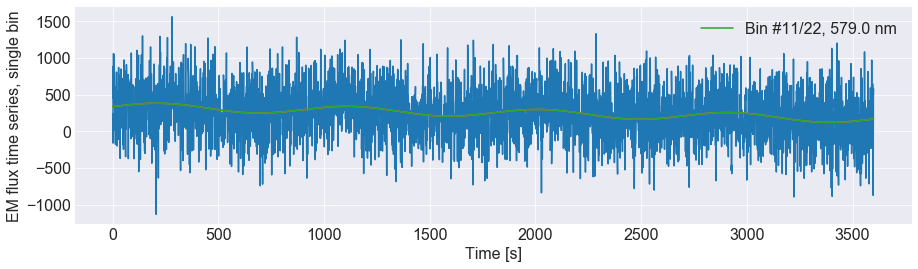


Actual midpoint time:  1568.160854884761
Measured midpoint time:  1588.6987108706473
Measured timing error [s]:  20.53785598588638
Max velocity error [cm/s]:  69.82871035201369



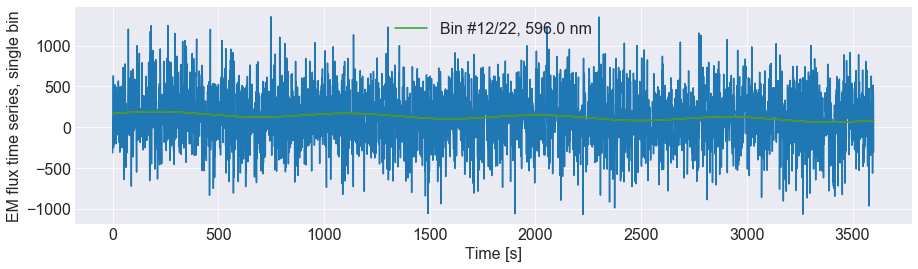


Actual midpoint time:  1568.1608548847607
Measured midpoint time:  1596.9423539320396
Measured timing error [s]:  28.781499047278885
Max velocity error [cm/s]:  97.8570967607482



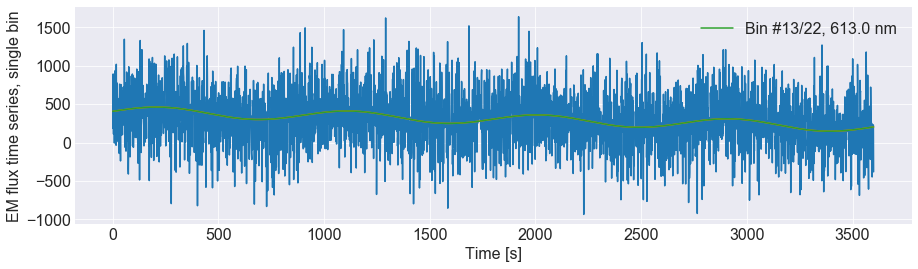


Actual midpoint time:  1568.160854884761
Measured midpoint time:  1537.9612350280247
Measured timing error [s]:  30.199619856736263
Max velocity error [cm/s]:  102.67870751290329



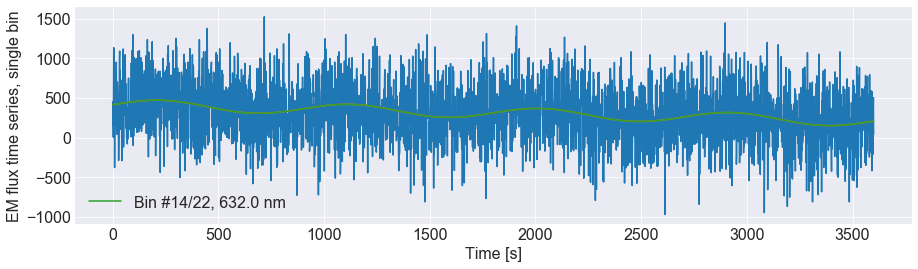


Actual midpoint time:  1568.1608548847612
Measured midpoint time:  1567.3217593603238
Measured timing error [s]:  0.8390955244374254
Max velocity error [cm/s]:  2.8529247830872464



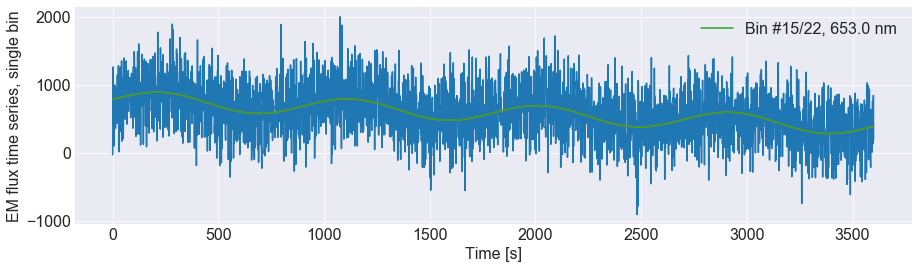


Actual midpoint time:  1568.160854884761
Measured midpoint time:  1532.1489660034704
Measured timing error [s]:  36.01188888129059
Max velocity error [cm/s]:  122.440422196388



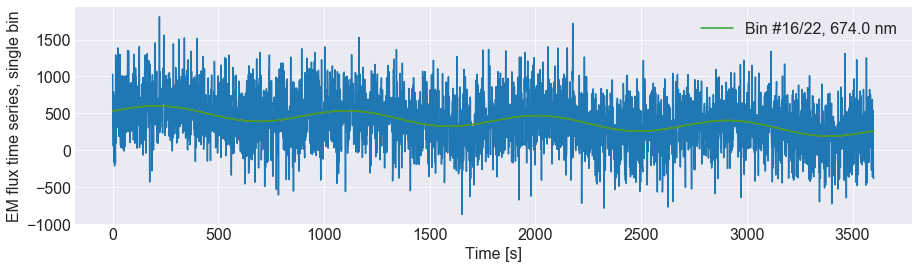


Actual midpoint time:  1568.1608548847607
Measured midpoint time:  1582.346579708937
Measured timing error [s]:  14.185724824176305
Max velocity error [cm/s]:  48.231464402199435



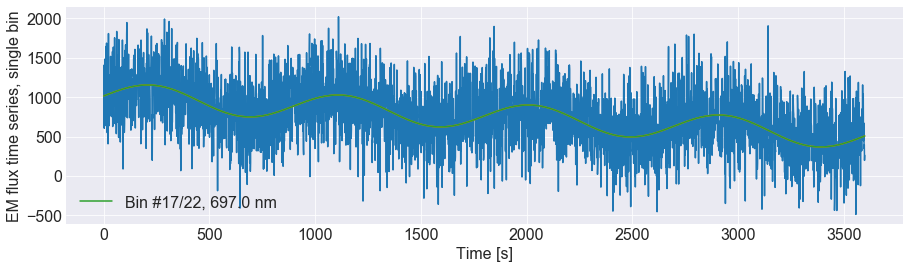


Actual midpoint time:  1568.1608548847612
Measured midpoint time:  1565.788256069375
Measured timing error [s]:  2.3725988153862545
Max velocity error [cm/s]:  8.066835972313266



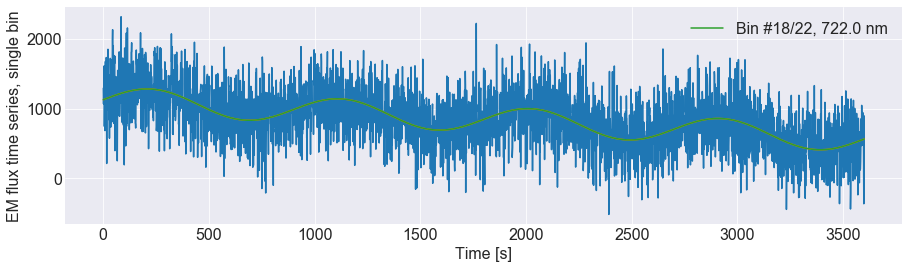


Actual midpoint time:  1568.160854884761
Measured midpoint time:  1570.9049473309105
Measured timing error [s]:  2.7440924461495797
Max velocity error [cm/s]:  9.329914316908571



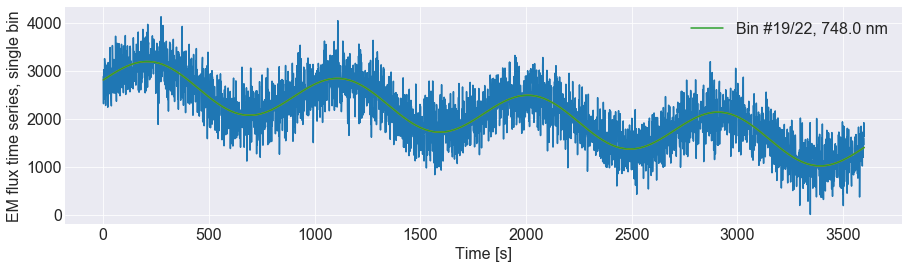


Actual midpoint time:  1568.160854884761
Measured midpoint time:  1560.5500234626934
Measured timing error [s]:  7.610831422067577
Max velocity error [cm/s]:  25.87682683502976



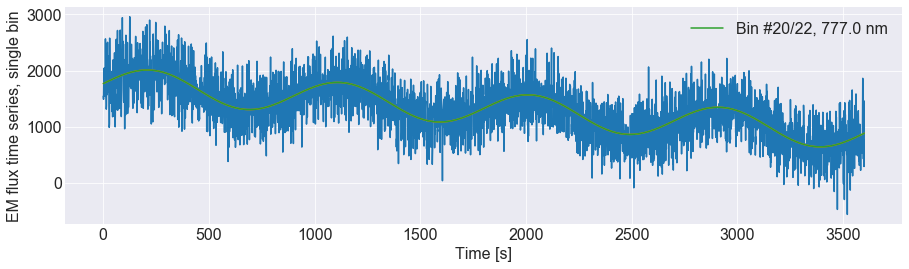


Actual midpoint time:  1568.160854884761
Measured midpoint time:  1564.423905050397
Measured timing error [s]:  3.7369498343639407
Max velocity error [cm/s]:  12.705629436837398



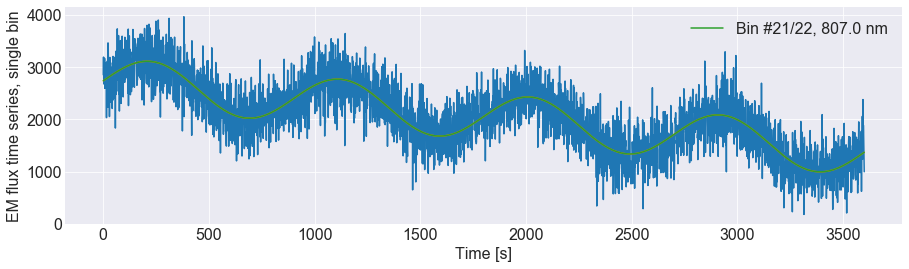


Actual midpoint time:  1568.160854884761
Measured midpoint time:  1568.7516465689125
Measured timing error [s]:  0.5907916841515544
Max velocity error [cm/s]:  2.0086917261152846



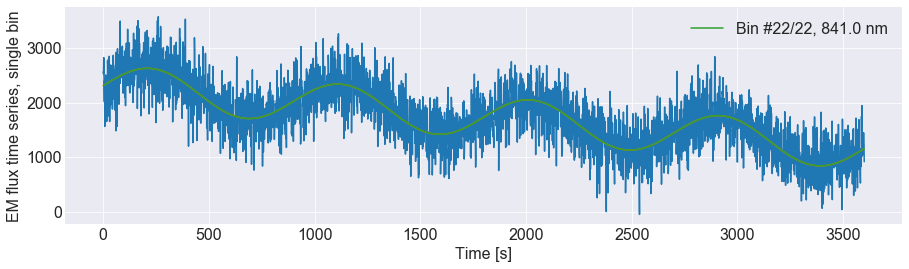

In [16]:

print('Expected observation RV uncertainty [cm/s]: ', sigma_rv_val * 1e2)
print('Mean KPF SNR: ', np.mean(snr_ord))

exp_midpoint_measured = []

# for each flux bin, generate a fake flux time series and estimate the flux-weighted midpoint
# each bin is treated independantly, for the purposes of this stress-test
for ind in range(n_bins):

    # make time series of flux recordings based on single flux rate
    flux_bin_noiseless = np.repeat(flux_rate[ind] * em_readout, len(time))
    flux_bin = flux_bin_noiseless.copy()

    # modulate the flux time series in different ways
    #------------------------------------------------------
    # modulate incoming flux rate randomly by some percentage
    # flux_mod = np.random.standard_normal(flux_bin.shape) * np.mean(flux_bin) * 0.05
    # flux_bin += flux_mod	# 5% modulation at 1s time scales
    # flux_bin_noiseless += flux_mod

    # modulate with sinusoid
    flux_mod_sin = np.sin(time * 8. * math.pi / np.amax(time))/4. + 1.5
    flux_mod_sin /= np.amax(flux_mod_sin)
    flux_bin *= flux_mod_sin
    flux_bin_noiseless *= flux_mod_sin

    # modulate with linear downward trend with time
    flux_mod_lin = (time[::-1]) / np.amax(time) * np.mean(flux_bin_noiseless)/2. - np.mean(flux_bin_noiseless)/2.
    flux_bin += flux_mod_lin
    flux_bin_noiseless += flux_mod_lin
    #------------------------------------------------------

    # add noise to flux time series
    #------------------------------------------------------
    # reference copy of photon noise alone
    flux_bin_photon = flux_bin.copy()
    
    # rescale to make sure total flux is conserved in noiseless case
    scale_fac = np.sum(flux_bin_noiseless) / (flux_rate[ind] * n_frames)
    flux_bin /= scale_fac
    flux_bin_photon /= scale_fac
    flux_bin_noiseless /= scale_fac
     
    # photon noise (gaussian errors)
    shot_noise = np.random.standard_normal(flux_bin.shape) * (np.mean(flux_bin)) ** 0.5
    flux_bin += shot_noise

    # add read noise and dark current
    pixel_noise = np.random.standard_normal(flux_bin.shape) * pixel_noise_sigma
    flux_bin += pixel_noise
    #------------------------------------------------------

    # calculate flux-weighted midpoint
    #------------------------------------------------------
    # flux-weighted light centroid time from 'measurements'
    t_centroid = np.sum(flux_bin * time) / np.sum(flux_bin)

    # actual light centroid time
    t_centroid_ref = np.sum(flux_bin_noiseless * time) / np.sum(flux_bin_noiseless)

    # timing error
    diff = np.abs(t_centroid - t_centroid_ref) # s
    max_vel_error = 3.4 # cm/s per second midpoint error
    vel_error = diff * max_vel_error # cm/s
    #------------------------------------------------------

    print('')
    print('Actual midpoint time: ', t_centroid_ref)
    print('Measured midpoint time: ',t_centroid)
    print('Measured timing error [s]: ', diff)
    print('Max velocity error [cm/s]: ', vel_error)
    print('')

    plt.plot(time, flux_bin)
    plt.plot(time, flux_bin_photon)
    plt.plot(time, flux_bin_noiseless, label='Bin #' + str(ind + 1) + '/' + str(n_bins) + ', ' + str(np.floor(wvl_bin[ind])) + ' nm')
    plt.legend(loc="best", ncol=1)
    plt.xlabel('Time [s]')
    plt.ylabel('EM flux time series, single bin')
    plt.show()
